# Multi-period OPF example

Re-create PyPower case from CSV files

In [64]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from nygrid.nygrid import NYGrid
from nygrid.run_nygrid import read_grid_profile, read_vre_data, read_electrification_data, run_nygrid_one_day
from nygrid.plots import plot_gen

In [65]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2030CLCPA')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

renewable_data_dir = os.path.join(data_dir, 'renewable')
print('Renewable data directory: {}'.format(renewable_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2030CLCPA
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Renewable data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load


## Read grid data

### Read generator profiles

In [66]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'),
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')
# Remove 'Bus' prefix in column names
load_profile.columns = load_profile.columns.str.replace('Bus', '').astype(int)

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'),
                          parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'),
                                parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

In [67]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read variable renewable energy (VRE) data

In [68]:
solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

vre_prop, genmax_profile_vre = read_vre_data(solar_data_dir,
                                             onshore_wind_data_dir,
                                             offshore_wind_data_dir)

Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/offshore_wind


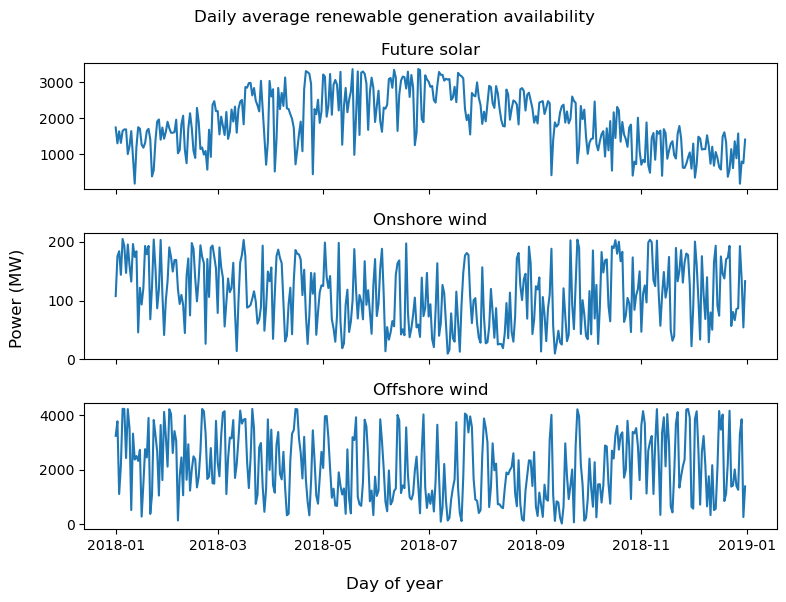

In [69]:
# Aggregate renewable generation
genmax_profile_future_solar = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('FutSol')]
genmax_sum_future_solar = genmax_profile_future_solar.sum(axis=1)
genmax_profile_onshore_wind = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('OnWind')]
genmax_sum_onshore_wind = genmax_profile_onshore_wind.sum(axis=1)
genmax_profile_offshore_wind = genmax_profile_vre.loc[:,
                                                      genmax_profile_vre.columns.str.contains('OffWind')]
genmax_sum_offshore_wind = genmax_profile_offshore_wind.sum(axis=1)

# Plot generation renewable availability
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all')
axs[0].plot(genmax_sum_future_solar.resample('D').mean(), label='Future solar')
axs[1].plot(genmax_sum_onshore_wind.resample('D').mean(), label='Onshore wind')
axs[2].plot(genmax_sum_offshore_wind.resample(
    'D').mean(), label='Offshore wind')

titles = ['Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Day of year')
fig.supylabel('Power (MW)')
fig.suptitle('Daily average renewable generation availability')
fig.tight_layout()

### Update load profile for electrification

In [70]:
res_building_data_dir = os.path.join(data_dir, 'load', 'residential_building')
print('Residential buildings data directory: {}'.format(res_building_data_dir))

com_building_data_dir = os.path.join(data_dir, 'load', 'commercial_building')
print('Commercial buildings data directory: {}'.format(com_building_data_dir))

electric_vehicle_data_dir = os.path.join(data_dir, 'load', 'electric_vehicle')
print('Electric vehicle data directory: {}'.format(electric_vehicle_data_dir))

# Read NYS county attributes and county to bus mapping
county_attrs = pd.read_csv(os.path.join(load_data_dir, 'county_attributes.csv'))
county_2_bus = pd.read_csv(os.path.join(load_data_dir, 'county_2_bus.csv'))

Residential buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/residential_building
Commercial buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/commercial_building
Electric vehicle data directory: /mnt/Bo_HDD/NYgrid-python/data/load/electric_vehicle


In [71]:
electrification_dict = {
    'res_building': {
        'data_dir': res_building_data_dir,
        'upgrade_id': 10,
        'scaling_factor': 0.3
    },
    'com_building': {
        'data_dir': com_building_data_dir,
        'upgrade_id': 18,
        'scaling_factor': 0.3
    },
    'electric_vehicle': {
        'data_dir': electric_vehicle_data_dir,
        'upgrade_id': 0,
        'scaling_factor': 0.3
    }
}

In [72]:
electrification_dict = read_electrification_data(electrification_dict,
                                                 county_attrs,
                                                 county_2_bus)

Get electrification data for 3 sectors:
['res_building', 'com_building', 'electric_vehicle']
Processing res_building electrification data...
Building load data is not available for county G3600030 Single-Family Attached. Skipping...
Building load data is not available for county G3600170 Single-Family Attached. Skipping...
Building load data is not available for county G3600230 Single-Family Attached. Skipping...
Building load data is not available for county G3600490 Single-Family Attached. Skipping...
Building load data is not available for county G3600510 Single-Family Attached. Skipping...
Building load data is not available for county G3600950 Single-Family Attached. Skipping...
Building load data is not available for county G3600970 Multi-Family with 5+ Units. Skipping...
Processing com_building electrification data...
Building load data is not available for county G3600010 Hospital. Skipping...
Building load data is not available for county G3600030 Outpatient. Skipping...
Build

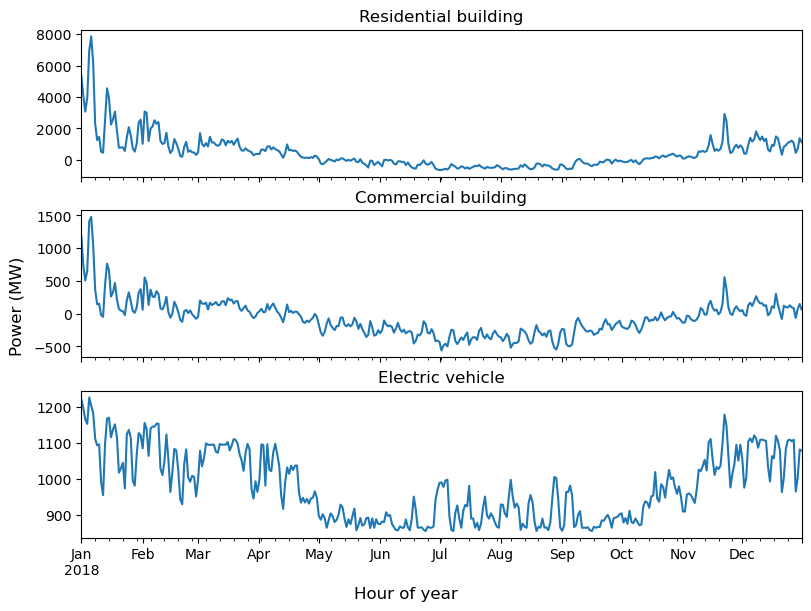

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')

res_building_profile = electrification_dict['res_building']['load_change']*electrification_dict['res_building']['scaling_factor']
com_building_profile = electrification_dict['com_building']['load_change']*electrification_dict['com_building']['scaling_factor']
electric_vehicle_profile = electrification_dict['electric_vehicle']['load_change']*electrification_dict['electric_vehicle']['scaling_factor']

res_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[0])
com_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[1])
electric_vehicle_profile.sum(axis=1).resample('D').mean().plot(ax=axs[2])

titles = ['Residential building', 'Commercial building', 'Electric vehicle']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
plt.show()

In [74]:
load_profile_elec = load_profile.copy()

for sector, attrs in electrification_dict.items():
    load_change = attrs['load_change'] * attrs['scaling_factor']
    load_profile_elec = load_profile_elec.add(load_change, fill_value=0)

load_profile_elec = load_profile_elec.sort_index(axis=1)
load_profile_elec = load_profile_elec.round(2)
load_profile_elec

,21,29,35,37,38,39,40,41,42,43,...,81,82,100,102,103,124,125,132,134,138
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,181.13,7520.01,2576.75,-0.0,77.36,430.29,21.39,1890.70,441.11,38.07,...,3716.30,3726.10,844.71,-265.53,10824.64,2558.77,1220.42,12534.12,-776.05,260.31
2018-01-01 01:00:00,166.20,7318.01,2484.81,-0.0,82.19,431.66,20.13,1827.93,423.05,45.23,...,3723.26,3736.04,816.22,-269.10,10513.99,2475.65,1183.23,12170.97,-759.27,252.25
2018-01-01 02:00:00,170.11,7119.11,2436.09,-0.0,86.29,435.16,22.50,1861.30,422.20,48.10,...,3667.51,3671.00,798.74,-255.38,10247.33,2426.94,1155.20,11844.65,-725.26,246.69
2018-01-01 03:00:00,162.38,7022.81,2391.07,0.0,92.32,444.78,26.00,1926.41,426.20,50.64,...,3695.54,3642.68,785.41,-260.28,10100.19,2388.94,1137.57,11666.82,-716.97,242.78
2018-01-01 04:00:00,156.74,6988.25,2368.13,-0.0,96.13,450.22,27.58,1975.46,432.93,53.21,...,3778.00,3691.90,776.85,-274.98,10053.39,2401.53,1132.01,11515.75,-670.13,242.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,170.71,7311.84,2491.59,-0.0,82.08,299.54,28.15,1467.68,361.56,23.36,...,3061.45,3294.55,843.98,-159.77,10382.58,2586.57,1191.57,11896.62,-602.86,258.79
2018-12-31 20:00:00,165.53,7041.44,2401.39,-0.0,74.42,283.77,25.58,1398.67,344.21,22.00,...,2953.58,3158.59,808.76,-177.27,10029.45,2499.32,1148.13,11436.74,-565.67,249.96
2018-12-31 21:00:00,190.93,6659.84,2347.98,-0.0,69.27,264.89,23.61,1325.92,326.62,20.60,...,2820.84,3016.28,763.75,-220.73,9663.44,2379.36,1098.11,10980.86,-558.10,238.66


In [75]:
load_profile_elec.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-28 17:00:00    93614.31
2018-08-29 16:00:00    93385.02
2018-08-28 16:00:00    93301.54
2018-08-29 17:00:00    93101.91
2018-08-29 15:00:00    92968.41
                         ...   
2018-05-13 05:00:00    36070.49
2018-10-14 04:00:00    36049.11
2018-05-14 03:00:00    35965.54
2018-05-13 03:00:00    35862.49
2018-05-13 04:00:00    35685.64
Length: 8760, dtype: float64

### Read DC line and ESR property file

In [76]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename)
dcline_prop

,DC_NAME,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,NPX1385+CSC,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,Neptune,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,HTP,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,VFT,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
4,CHPE,48,81,1,0.000000,0,0,0,1.01,1,-1250,1250,-100,100,-100,100,0,0,D,J
5,CPNY,69,81,1,0.000000,0,0,0,1.01,1,-1300,1300,-100,100,-100,100,0,0,E,J


In [77]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K
8,A_ESR_Standalone,56,1,300.0,300.0,0.85,0.85,0,1200,600,600,0.005,0.005,A
9,B_ESR_Standalone,53,1,180.0,180.0,0.85,0.85,0,720,360,360,0.005,0.005,B


## Multi-period OPF

### Without initial conditions

In [78]:
# Only run for one day
d = 240
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-30 23:00:00


In [79]:
# 2 nuclear generators are retired
indian_point_names = [
    'Nuclear_H_0_0', # Gen232
    'Nuclear_H_1_0' # Gen233
]

# 11 gas turbines are retired due to Peaker rule
retire_peaker_names = [
    "Brentwood", # Gen57
    "Gowanus 5", # Gen128
    "Gowanus 6", # Gen129
    "Harlem River 1", # Gen132
    "Harlem River 2", # Gen133
    "Hellgate 1", # Gen134
    "Hellgate 2", # Gen135
    "Kent", # Gen159
    "Pouch", # Gen195
    "Vernon Blvd 2", # Gen222
    "Vernon Blvd 3", # Gen223
]

# Remaining number of generators is 303 - 2 - 11 = 290

#### Without ESR

In [80]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir,
                           start_datetime=start_datetime,
                           end_datetime=end_datetime,
                           dcline_prop=dcline_prop,
                           esr_prop=None,
                           vre_prop=None,
                           verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile_elec)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpdmy4e4ky.pyomo.lp
Reading time = 0.26 seconds
x1: 77780 rows, 63649 columns, 397020 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 77780 rows, 63649 columns and 397020 nonzeros
Model fingerprint: 0xccf25340
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 71630 rows and 48715 columns
Presolve time: 0.12s
Presolved: 6150 rows, 14934 columns, 62079 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.823e+04
 Factor NZ  : 2.059e+05 (rou

In [81]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [82]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile_elec)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpnjw6yn2d.pyomo.lp
Reading time = 0.29 seconds
x1: 92150 rows, 80929 columns, 432900 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 92150 rows, 80929 columns and 432900 nonzeros
Model fingerprint: 0xa65b5098
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 78547 rows and 55632 columns
Presolve time: 0.16s
Presolved: 13603 rows, 25297 columns, 85666 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 6.566e+04
 Factor NZ  : 3.417e+05 (ro

In [83]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [84]:
# Create NYGrid object
nygrid_sim_w_vre = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=None,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre.set_load_sch(load_profile_elec)
nygrid_sim_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre.solve_dc_opf()

# Get results
results_0_w_vre = nygrid_sim_w_vre.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpsyi1bn92.pyomo.lp
Reading time = 0.28 seconds
x1: 91080 rows, 73729 columns, 430200 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 91080 rows, 73729 columns and 430200 nonzeros
Model fingerprint: 0xc82e8d90
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 84441 rows and 56701 columns
Presolve time: 0.14s
Presolved: 6639 rows, 17028 columns, 72017 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.600e+04
 Factor NZ  : 2.248e+05 (rou

In [85]:
print("s_ramp_up", results_0_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre['s_load_shed'].sum())
print("s_if_max", results_0_w_vre['s_if_max'].sum())
print("s_if_min", results_0_w_vre['s_if_min'].sum())
print("s_br_max", results_0_w_vre['s_br_max'].sum())
print("s_br_min", results_0_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 165.71839793667564
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [86]:
# Create NYGrid object
nygrid_sim_w_vre_esr = NYGrid(grid_data_dir,
                              start_datetime=start_datetime,
                              end_datetime=end_datetime,
                              dcline_prop=dcline_prop,
                              esr_prop=esr_prop,
                              vre_prop=vre_prop,
                              verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre_esr.set_load_sch(load_profile_elec)
nygrid_sim_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre_esr.solve_dc_opf()

# Get results
results_0_w_vre_esr = nygrid_sim_w_vre_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpg1cp64ej.pyomo.lp
Reading time = 0.31 seconds
x1: 105450 rows, 91009 columns, 466080 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 105450 rows, 91009 columns and 466080 nonzeros
Model fingerprint: 0x33874ed0
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 91358 rows and 63639 columns
Presolve time: 0.18s
Presolved: 14092 rows, 27370 columns, 95677 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.417e+04
 Factor NZ  : 3.589e+05 (

In [87]:
print("s_ramp_up", results_0_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_0_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_0_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_0_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 1199.2183979366753
s_br_max 0.0
s_br_min 0.0


#### Results

In [88]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, -0.2, -0.038062283737024874, -0.2, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, -0.2, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01700000000000011, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01700000000000011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.2, 0.038062283737024874, 0.2, 0.0, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2]
SOC [1.0, 1.0, 1.17, 1.202352941176471, 1.372352941176471, 1.372352941176471, 1.542352941176471, 1.7123529411764709, 1.8823529411764708, 1.8823529411764708, 1.8823529411764

In [89]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}, {results_0_w_vre["total_cost"].sum():.2f}, {results_0_w_vre_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}, {results_0_w_vre["gen_cost"].sum():.2f}, {results_0_w_vre_esr["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}, {results_0_w_vre["over_gen_penalty"].sum():.2f}, {results_0_w_vre_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}, {results_0_w_vre["load_shed_penalty"].sum():.2f}, {results_0_w_vre_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_vre["ramp_up_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_vre["ramp_down_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}, {results_0_w_vre["if_max_penalty"].sum():.2f}, {results_0_w_vre_esr["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}, {results_0_w_vre["if_min_penalty"].sum():.2f}, {results_0_w_vre_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}, {results_0_w_vre["br_max_penalty"].sum():.2f}, {results_0_w_vre_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}, {results_0_w_vre["br_min_penalty"].sum():.2f}, {results_0_w_vre_esr["br_min_penalty"].sum():.2f}')

Total cost: 120003817.51, 118113206.39, 112162475.17, 120766095.07
Gen cost: 120003817.51, 118112685.59, 110505291.19, 108773437.91
Over generation penalty: 0.00, 0.00, 0.00, 0.00
Load shed penalty: 0.00, 0.00, 0.00, 0.00
Ramp up penalty: 0.00, 0.00, 0.00, 0.00
Ramp down penalty: 0.00, 0.00, 0.00, 0.00
Interface max penalty: 0.00, 0.00, 0.00, 0.00
Interface min penalty: 0.00, 0.00, 1657183.98, 11992183.98
Branch max penalty: 0.00, 0.00, 0.00, 0.00
Branch min penalty: 0.00, 0.00, 0.00, 0.00


In [90]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index(
    'BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [91]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

lmp_w_vre = results_0_w_vre['LMP']
lmp_w_vre.columns = bus_names

lmp_w_vre_esr = results_0_w_vre_esr['LMP']
lmp_w_vre_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.T.groupby(bus_zone_alloc).mean().T
lmp_w_esr_zone = lmp_w_esr.T.groupby(bus_zone_alloc).mean().T
lmp_w_vre_zone = lmp_w_vre.T.groupby(bus_zone_alloc).mean().T
lmp_w_vre_esr_zone = lmp_w_vre_esr.T.groupby(bus_zone_alloc).mean().T

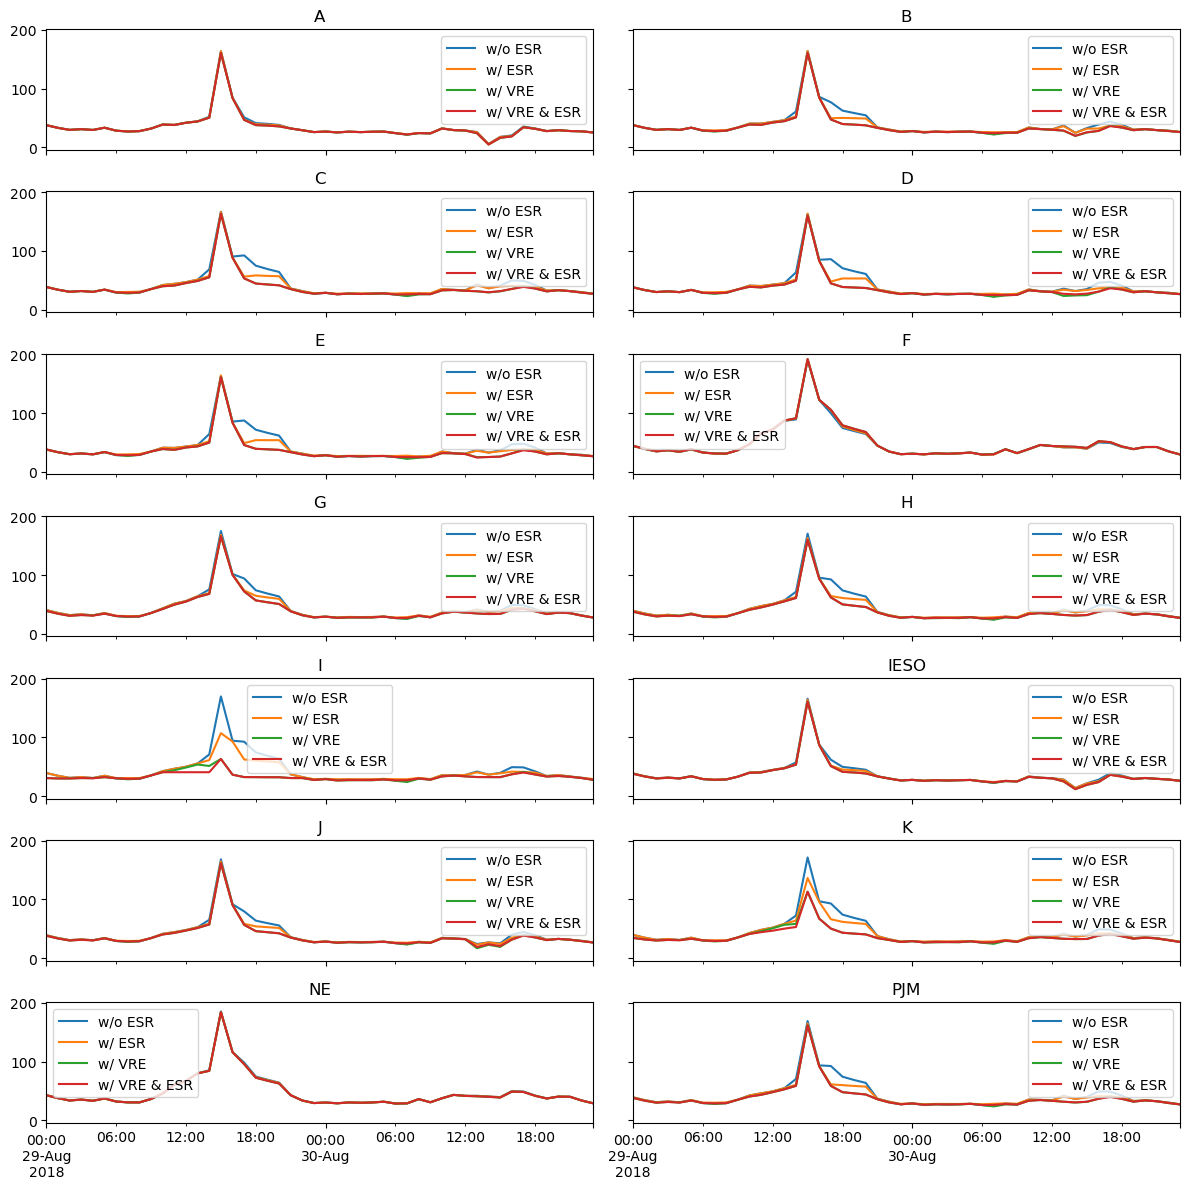

In [92]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    lmp_w_vre_zone.iloc[:, i].plot(ax=ax, label='w/ VRE')
    lmp_w_vre_esr_zone.iloc[:, i].plot(ax=ax, label='w/ VRE & ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()

fig.tight_layout()

<Axes: title={'center': 'Zonal Load'}, xlabel='TimeStamp'>

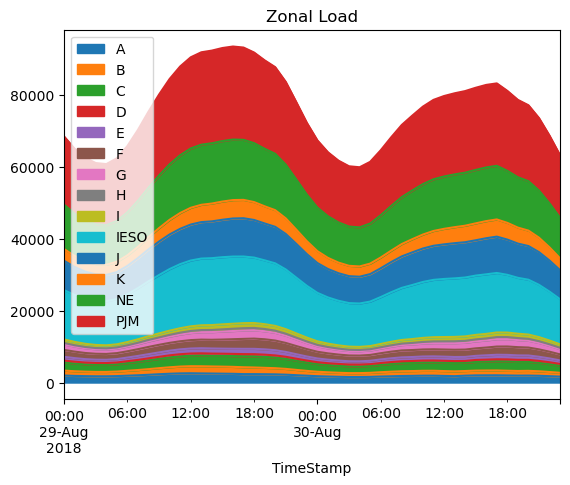

In [93]:
load_profile_elec.columns = bus_names
load_profile_zone = load_profile_elec.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

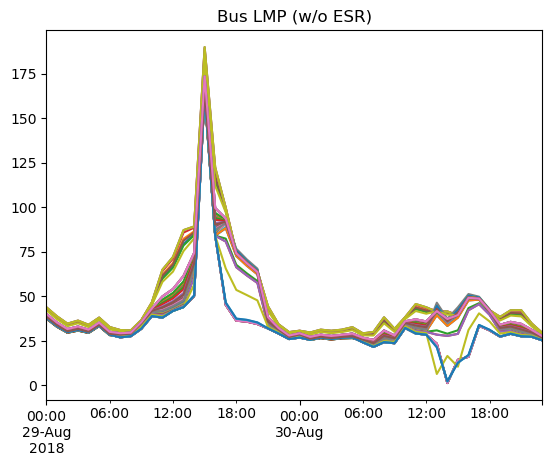

In [94]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

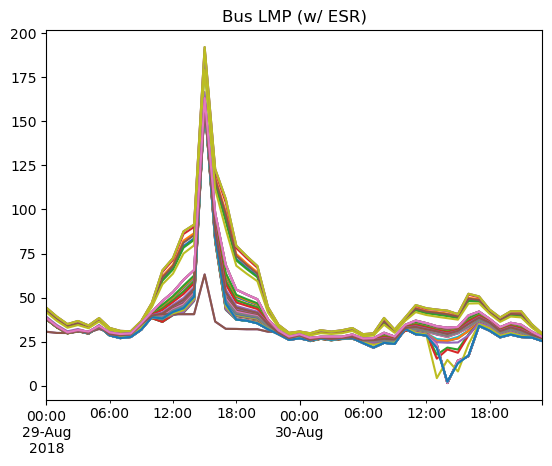

In [95]:
results_0_w_vre_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

### With initial conditions

In [96]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


#### Without ESR

In [97]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir,
                             start_datetime=start_datetime,
                             end_datetime=end_datetime,
                             dcline_prop=dcline_prop,
                             esr_prop=None,
                             verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpv91gv3is.pyomo.lp
Reading time = 0.26 seconds
x1: 78384 rows, 63649 columns, 398228 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 78384 rows, 63649 columns and 398228 nonzeros
Model fingerprint: 0xcb3a64fc
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 72337 rows and 48818 columns
Presolve time: 0.12s
Presolved: 6047 rows, 14831 columns, 60482 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.604e+04
 Factor NZ  : 2.111e+05 (rou

In [98]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [99]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set storage initial SOC condition
last_soc = results_0_w_esr['esrSOC'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpb5u4oxet.pyomo.lp
Reading time = 0.29 seconds
x1: 92814 rows, 80929 columns, 434228 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 92814 rows, 80929 columns and 434228 nonzeros
Model fingerprint: 0xe93f1f5e
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 79331 rows and 55752 columns
Presolve time: 0.16s
Presolved: 13483 rows, 25177 columns, 83446 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 6.299e+04
 Factor NZ  : 3.399e+05 (ro

In [100]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [101]:
# Create NYGrid object
nygrid_sim_1_w_vre = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre.set_load_sch(load_profile_elec)
nygrid_sim_1_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre.solve_dc_opf()

# Get results
results_1_w_vre = nygrid_sim_1_w_vre.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpoqghywru.pyomo.lp
Reading time = 0.28 seconds
x1: 91824 rows, 73729 columns, 431688 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 91824 rows, 73729 columns and 431688 nonzeros
Model fingerprint: 0xffff1213
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 85340 rows and 56860 columns
Presolve time: 0.14s
Presolved: 6484 rows, 16869 columns, 70423 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.258e+04
 Factor NZ  : 2.166e+05 (rou

In [102]:
print("s_ramp_up", results_1_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre['s_load_shed'].sum())
print("s_if_max", results_1_w_vre['s_if_max'].sum())
print("s_if_min", results_1_w_vre['s_if_min'].sum())
print("s_br_max", results_1_w_vre['s_br_max'].sum())
print("s_br_min", results_1_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [103]:
# Create NYGrid object
nygrid_sim_1_w_vre_esr = NYGrid(grid_data_dir,
                                start_datetime=start_datetime,
                                end_datetime=end_datetime,
                                dcline_prop=dcline_prop,
                                esr_prop=esr_prop,
                                vre_prop=vre_prop,
                                verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre_esr.set_gen_init_data(gen_init=last_gen)

# Set storage initial SOC condition
last_soc = results_0_w_vre_esr['esrSOC'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre_esr.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre_esr.solve_dc_opf()

# Get results
results_1_w_vre_esr = nygrid_sim_1_w_vre_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpwkkxx2oe.pyomo.lp
Reading time = 0.32 seconds
x1: 106254 rows, 91009 columns, 467688 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 106254 rows, 91009 columns and 467688 nonzeros
Model fingerprint: 0x6ee50889
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 92291 rows and 63810 columns
Presolve time: 0.19s
Presolved: 13963 rows, 27199 columns, 93225 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.077e+04
 Factor NZ  : 3.478e+05 (

In [104]:
print("s_ramp_up", results_1_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_1_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_1_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_1_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

In [105]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [106]:
# Format results
thermal_pg_0_wo_esr = (results_0_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_0_w_esr = (results_0_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_0_w_vre = (results_0_w_vre['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_0_w_vre_esr = (results_0_w_vre_esr['PG'].iloc[:, :num_thermal]
                          .rename(columns=gen_rename))

thermal_pg_1_wo_esr = (results_1_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_1_w_esr = (results_1_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_w_vre = (results_1_w_vre['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_w_vre_esr = (results_1_w_vre_esr['PG'].iloc[:, :num_thermal]
                          .rename(columns=gen_rename))

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object

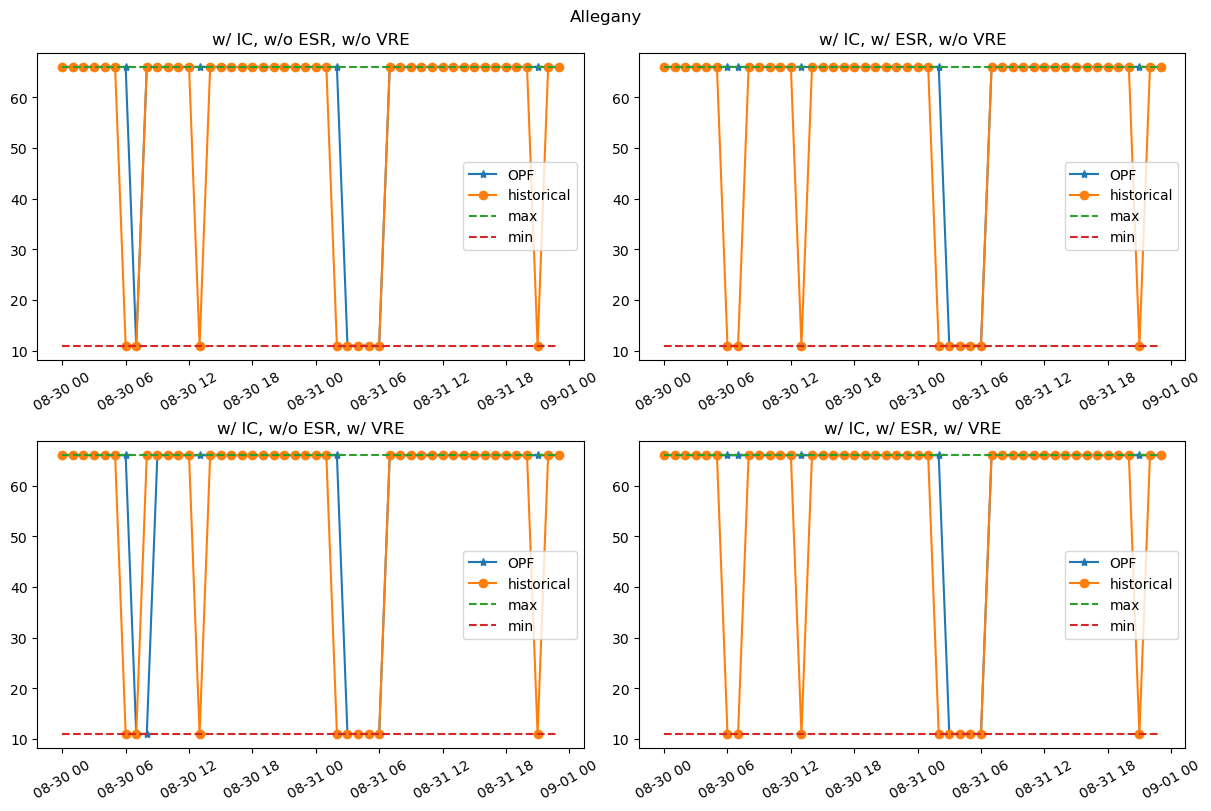

In [107]:
ii = 3
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object

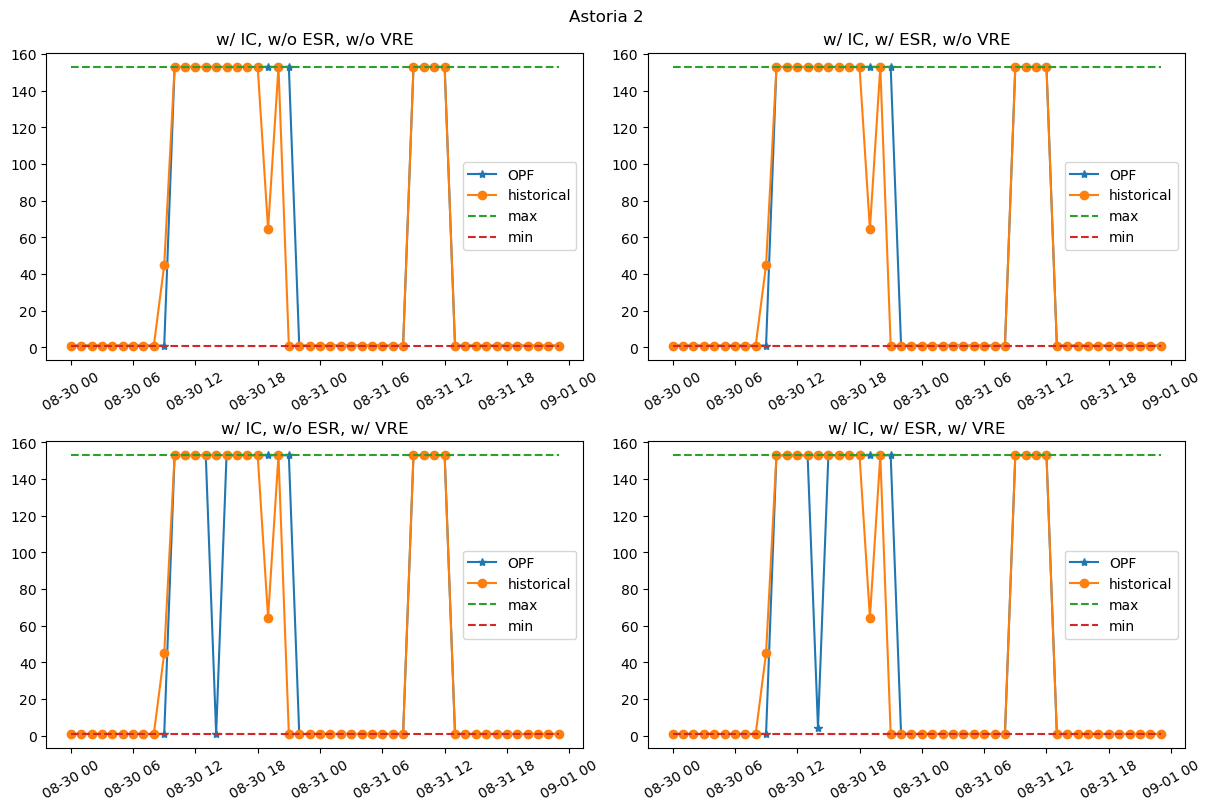

In [108]:
ii = 9
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object

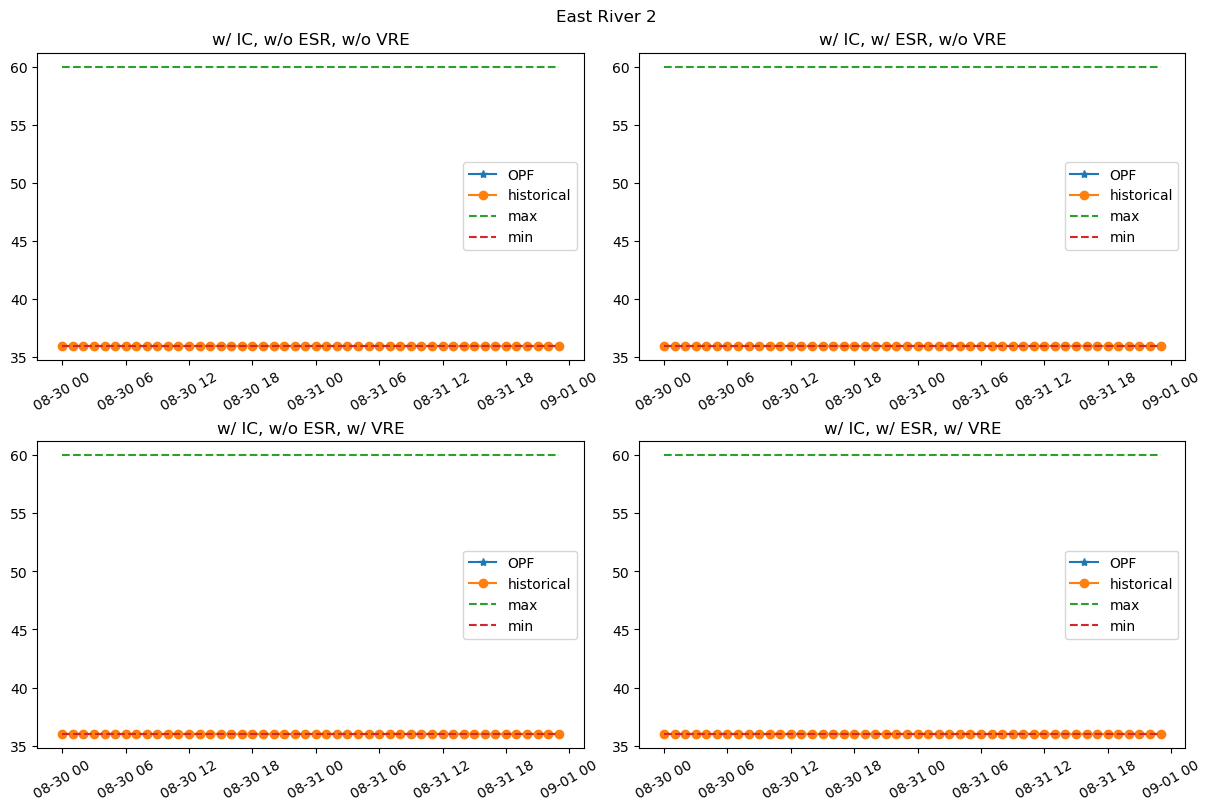

In [109]:
ii = 83
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()